In [1]:
import os

import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
import seaborn as sns

# Style
sns.set_theme(context='talk', style='white', palette='Set2')
plt.rcParams.update({
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'font.size': 22,
    'axes.titlesize': 'medium',
    'axes.labelsize': 'large',
    'xtick.labelsize': 'medium',
    'ytick.labelsize': 'medium',
    'legend.fontsize': 'medium',
    'legend.title_fontsize': 'medium',
    'figure.titlesize': 'x-large',
})

# Directories
DATA_DIR = '../../data'
PLOT_DIR = '../plots'

# Seed
np.random.seed(42)

In [2]:
# Read data
df = pd.read_csv(os.path.join(DATA_DIR, 'celltype_importance.csv'))
df = df.rename(columns={
    'celltype': 'Cell Type',
    'cell_group': 'Super',
    'imp_score_mean': 'Prioritization',
    'imp_score_std': 'Prioritization STD',
    'cell_frac_mean': 'Fraction',
    'cell_frac_std': 'Fraction STD',
    'phenotype_x': 'Phenotype',
})

# # Generate fake data
# df = pd.DataFrame({'Cell Type': [f'CELLTYPE_{i:02}' for i in range(12)]})
# df['Prioritization'] = [np.random.rand() for i in range(df.shape[0])]
# df['std'] = [np.random.rand() for i in range(df.shape[0])]
# df['Fraction'] = [np.random.rand() for i in range(df.shape[0])]

# # Generate fake glial-neuronal classification
# glial_to_neuronal = {
#     ct: ['Glial', 'Neuronal'][np.random.choice(2, 1)[0]]
#     for ct in df['Cell Type'].unique()}

# # Add classification to data
# df['Super'] = df['Cell Type'].map(lambda ct: glial_to_neuronal[ct])

# Sort
df = df.sort_values('Prioritization', ascending=False)

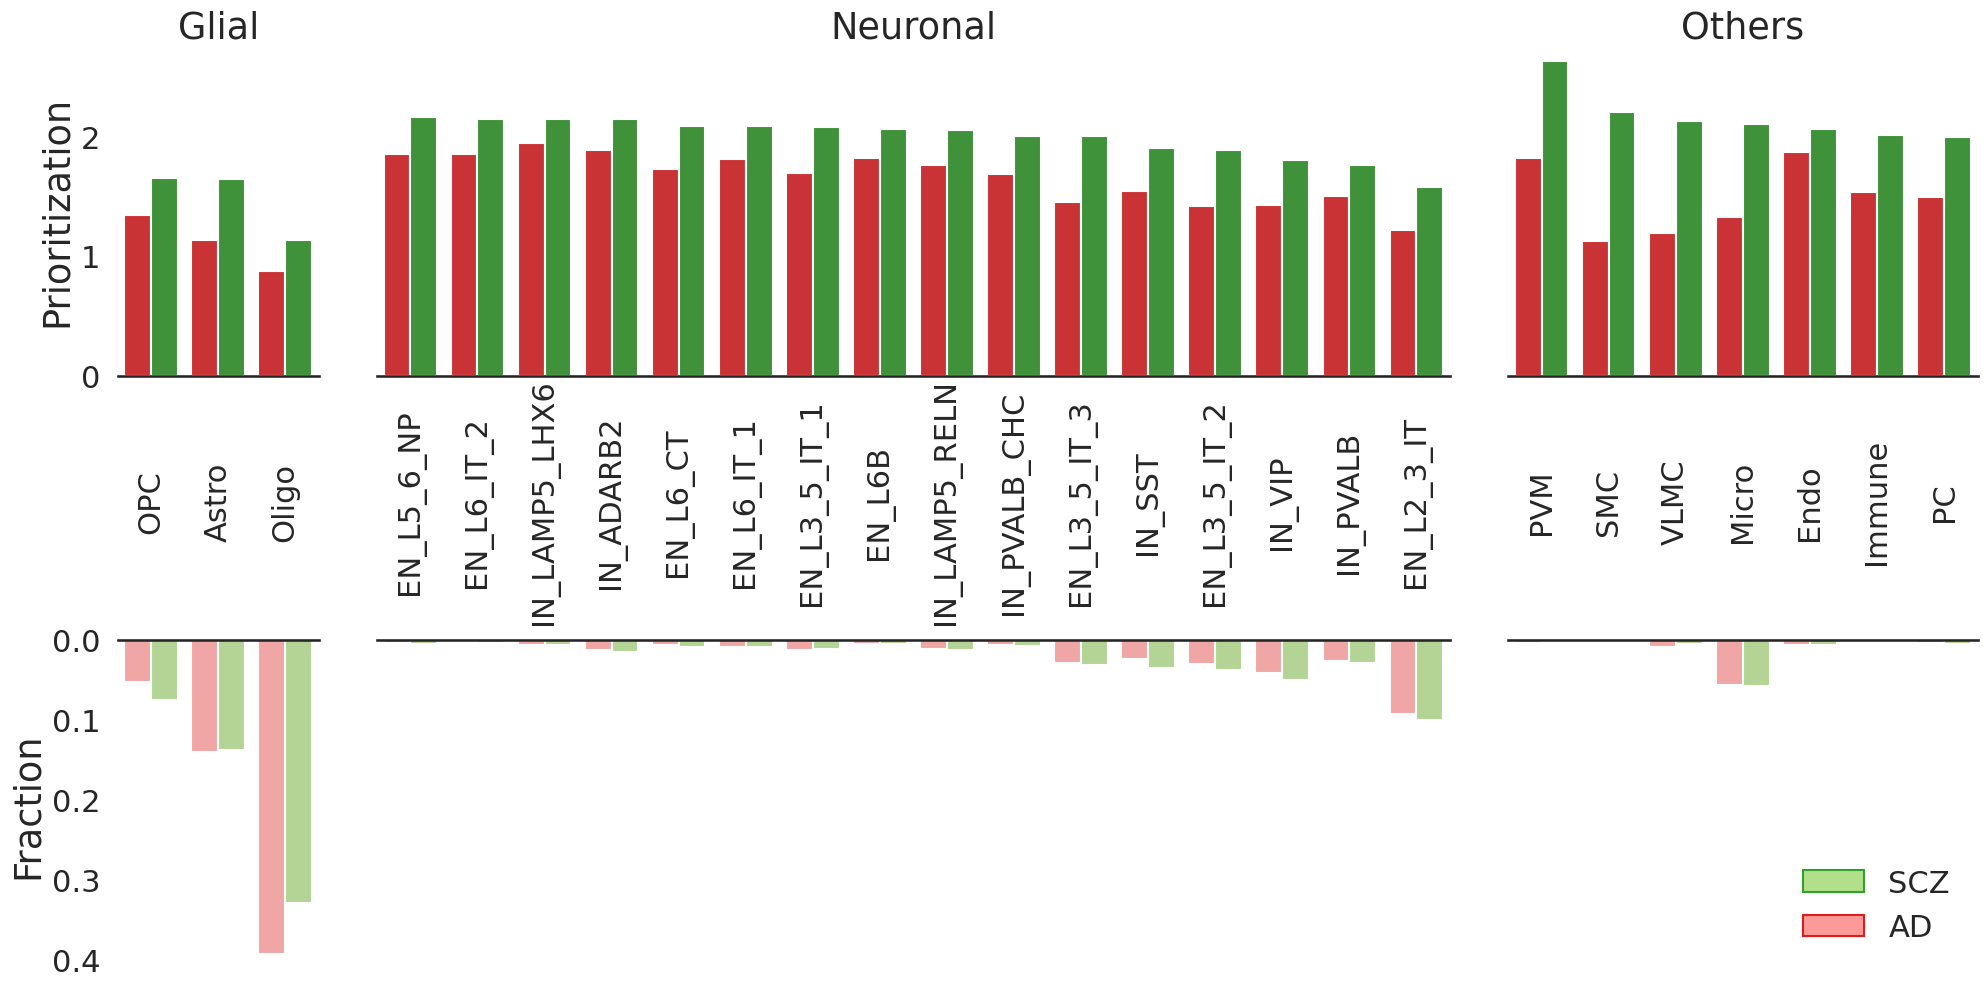

In [20]:
# Parameters
label_hspace = .8
plot_wspace = .1
order = ('Glial', 'Neuronal', 'Others')

# Create figure
fig, axs = plt.subplots(
    2, len(order),
    gridspec_kw={'hspace': label_hspace, 'wspace': plot_wspace},
    width_ratios=[(df['Super'] == sup).sum() for sup in order],
    figsize=(24, 12))

# Loop arguments
arrangement = (
    [(sup, 'Prioritization', (0, i)) for i, sup in enumerate(order)]
    + [(sup, 'Fraction', (1, i)) for i, sup in enumerate(order)]
)

# Arrange figure
for sup, feature, ax_loc in arrangement:
    # Get params
    ax = axs[ax_loc[0], ax_loc[1]]

    # Filter data
    # TODO: Add sorting
    df_sub = df[(df['Super'] == sup)]
    ### CT GROUPED X
    labels = df_sub['Cell Type'].unique()
    ### UNGROUPED X
    # labels = df_sub['Cell Type'].to_list()
    ### END
    y = df_sub[feature].to_numpy()

    # Plot
    # sns.barplot(data=df, x='Cell Type', y=feature, hue='Phenotype', ax=ax)
    # color = '#b3669e' if ax_loc[0] == 0 else '#98984d'
    COLORS = {
        'AD': sns.color_palette('Paired')[5:3:-1],
        'SCZ': sns.color_palette('Paired')[3:1:-1],
    }
    ### CT GROUPED X
    palette = [COLORS[ord][ax_loc[0]] for ord in list(COLORS)]
    sns.barplot(
        data=df_sub,
        x='Cell Type',
        y=feature,
        hue='Phenotype',
        hue_order=list(COLORS),
        palette=sns.color_palette(palette),
        ax=ax)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.legend([],[], frameon=False)
    ### UNGROUPED X
    # color = df_sub['Phenotype'].map(lambda s: COLORS[s][ax_loc[0]])
    # ax.bar(range(y.shape[0]), y, color=color)
    ### END

    # Error bars
    # ax.errorbar(range(y.shape[0]), y, yerr=df_sub[f'{feature} STD'], fmt='o', color='black')

    # y-conditional formatting
    if ax_loc[0] == 0:  # Top
        # Set title
        ax.set_title(sup, fontsize='large')

        # Remove spines
        ax.spines['top'].set_visible(False)

        # Place x Labels
        transform = transforms.blended_transform_factory(ax.transData, fig.transFigure)
        for i, label in enumerate(labels):
            ax.text(i, .5, label, ha='center', va='center', rotation=90, transform=transform)

    else:  # Bottom
        # Remove spines
        ax.spines['bottom'].set_visible(False)

    # Set limits
    ax.set_xlim(left=-.5, right=len(labels)-.5)
    ax.set_ylim(bottom=0)

    # x-conditional formatting
    if ax_loc[1] == 0:  # Left
        ax.set_ylabel(feature)

    else:  # Right
        # Hide y axis labels
        ax.tick_params(labelleft=False)

    # Hide x axis labels
    ax.tick_params(labelbottom=False)

    # Remove spines
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Match limits (needed otherwise weird prioritization on axis limits when sharing)
for y in range(2):
    # Get ranges
    lim_min = min(axs[y, i].get_ylim()[0] for i in range(len(order)))
    lim_max = max(axs[y, i].get_ylim()[1] for i in range(len(order)))

    # Set ranges
    for i in range(len(order)):
        axs[y, i].set_ylim(lim_min, lim_max)


# Share axes and invert
for x in range(len(order)): axs[0, x].sharex(axs[1, x])
for y in range(2):
    for x in range(len(order)-1):
        axs[y, x].sharey(axs[y, x+1])
axs[1, 0].invert_yaxis()

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=COLORS[ph][1], edgecolor=COLORS[ph][0], label=ph) for ph in df_sub['Phenotype'].unique()]
axs[-1, -1].legend(handles=legend_elements, frameon=False, loc='lower right')

# Save figure
fig.savefig(os.path.join(PLOT_DIR, f'figure_5_prioritization.pdf'), bbox_inches='tight')
plt.show()
plt.close()